# Лабораторная работа №1
#### Выполнил: Нистратов Д.Г. гр.9383 
#### Вариант 12
## Цель работы 
Изучить возможности библиотек Python для решения задач цифровой обработки сигналов.
## Задачи лабораторной работы
1. Освоить Jupyter Notebook.
2. Выполнить загрузку аудио сигнала и построить огибающую (график).
3. Фильтрация (выбрать один из 4 основных типов фильтров). Получить фильтрованный сигнал.
4. Детектор сигнал/шум. Получить сигнал после детектирования
5. Эффект ”Эхо”. Получить сигнал после работы аудио-эффекта.
6. Бонусное задание: эффект ”Distortion”(классический вариант). Получить сигнал после работы аудио-эффекта.

## Загрузка аудио синала и построение огибающей

### Загрузка аудио сигнала
Загрузка сигнала из файла реализованна с помощью библиотеки scipy. Из-за особенности строения wav файла, scipy выдает предупреждение, что файл содержит незнакомый Chunk ("Чанк") информации. Это происходит из-за того что в чанках храниться дополнительная инфомация (copyright, название трека и т.д)

C:\Users\boogu\AppData\Local\Temp/ipykernel_16044/1264227623.py:8: WavFileWarning: Chunk (non-data) not understood, skipping it.
  framerate, signal = wavfile.read(file_name)


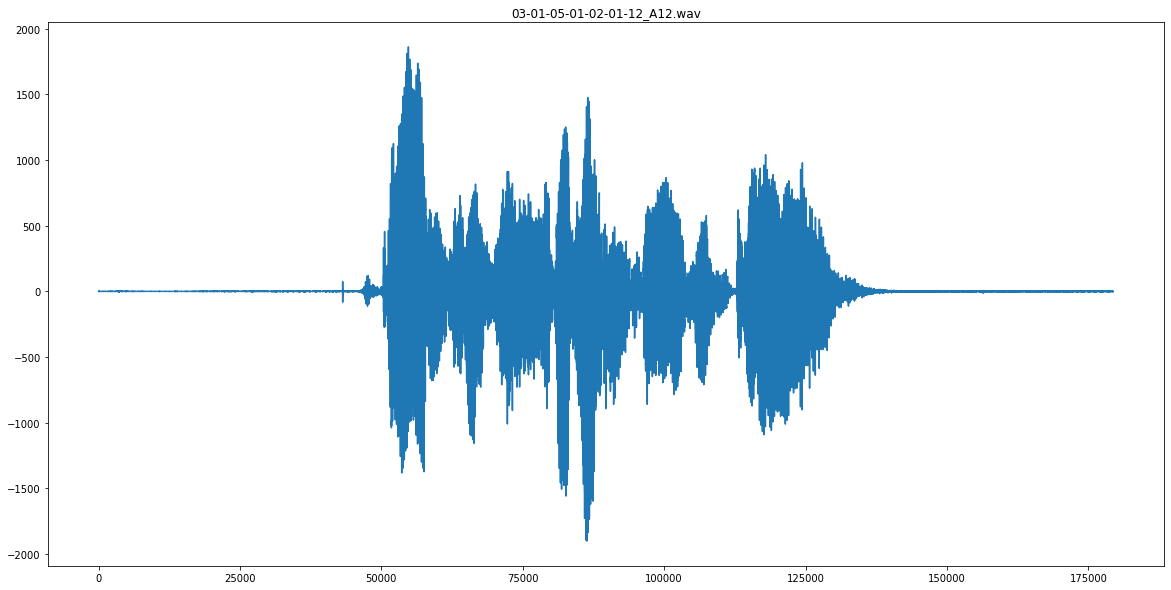

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.io import wavfile


file_name = "03-01-05-01-02-01-12_A12.wav"

framerate, signal = wavfile.read(file_name)

plt.figure(figsize=(20, 10))
plt.title(file_name)
plt.plot(signal)
plt.show()

Имеется сигнал $ x(i), i=0,1,...,N-1 $. Хотим построить огибающую $ y(j), j=0,1,...,n-1 $.

Пусть $ m=[\frac{N}{n}]$ - число точек в интервале усреднения. Тогда
$$y(j)=\frac{1}{m}\sum_{k=mj}^{mj+m-1} |x(k)|$$


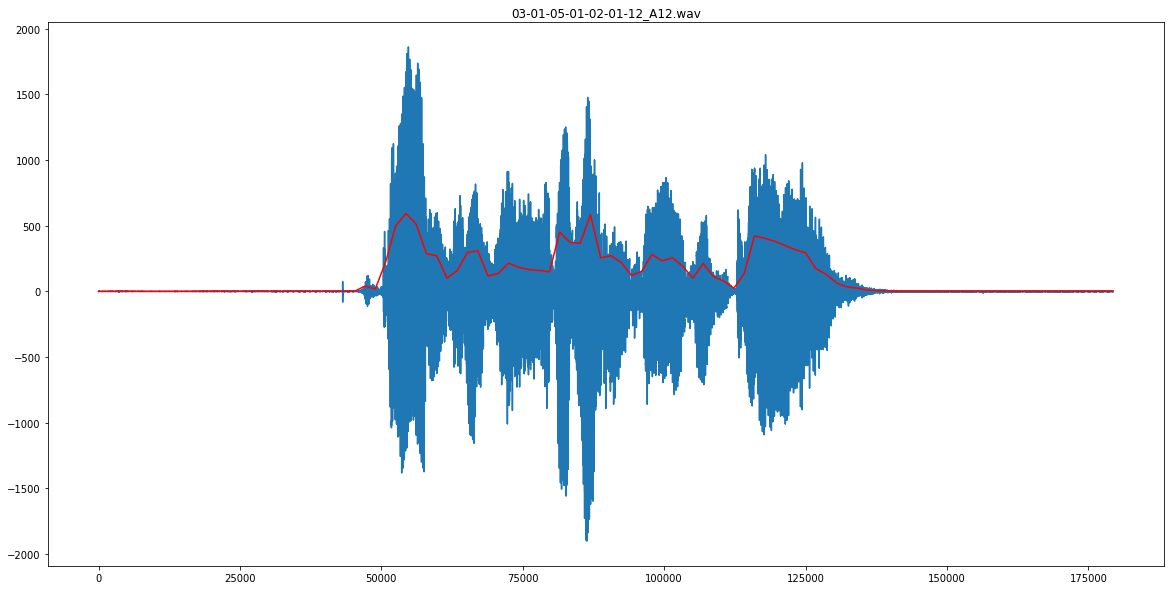

In [19]:
def curve(n):
    N = len(signal)
    m = np.floor_divide(N, n)
    y = [np.sum(np.abs(signal[m * j : m * j + m - 1]))/m for j in range(n)]
    return (np.linspace(start=0, stop=N, num=n), y)

x, y = curve(100)
plt.figure(figsize=(20, 10))
plt.title(file_name)
plt.plot(signal)
plt.plot(x, y, color='red')
plt.show()

## Фильтрация с помощью фильтра верхних частот
Пусть $F_{d}$ - частота дискретизации, частота среза - $F_{s}$. порядок фильтра - $m$. Тогда вычисляем

$$wn = 2\frac{F_{s}}{F_{d}}$$

С помощью библиотеки scipy сделаем фильтрацию верхних частот

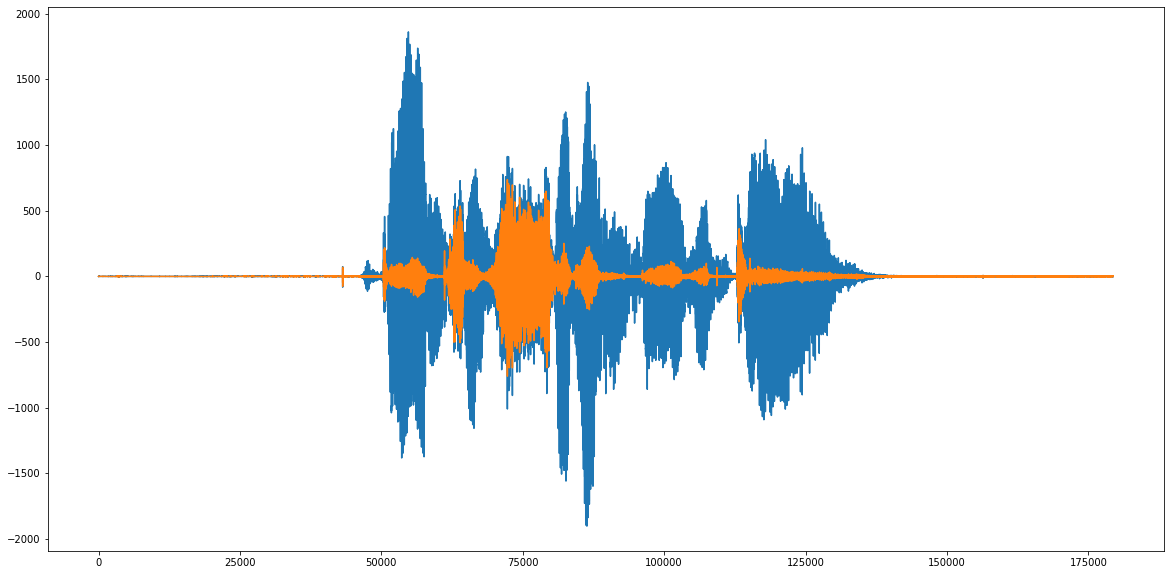

In [3]:
from scipy import signal as scipy_signal
from scipy.io.wavfile import write

def filter(order, freq):
    b, a = scipy_signal.butter(order, 2*freq/framerate, 'highpass')
    filtedData = scipy_signal.filtfilt(b, a, signal)
    return filtedData

filted = filter(1, 5000)
plt.figure(figsize=(20, 10))
plt.plot(signal)
plt.plot(filted)
plt.show()

write("highpass.wav", framerate, filted.astype(np.int16))

## Амплитудный детектор сигнал/шум
Определяем среднее сигнала по амплитуде (без учета знака):

$$mid=\frac{1}{N}\sum_{k=0}^{N-1} |x(k)|$$
Определяем порог детектора — $ Th = \alpha * mid $, где $ 0 \lt \alpha \lt 1 $ подбирается экспериментально.
Задаем величину ”провала”(в отсчетах) — $ k $. Обозначим $ y(i) $ — сигнал после детектирования.

Событие ”начало сигнала”. Если $ x(i) $ в течении $ k $ отсчетов превышает порог, $ y(i) = x(i) $

Событие ”окончание сигнала”. Если $ x(i) $ в течении $ k $ отсчетов меньше порога, $ y(i)=0 $

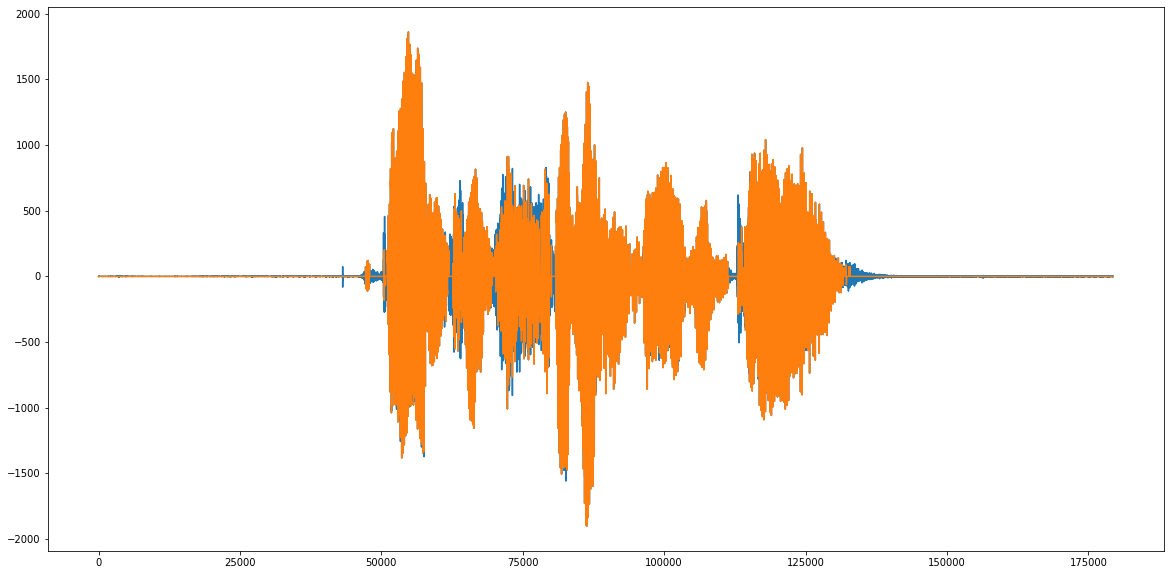

In [4]:
mid = np.sum(np.abs(signal))/len(signal)
a = 0.5
Th = a * mid
k = 10

y = np.empty(len(signal), dtype=np.int16)
for i in range(len(signal)):
    y[i] = signal[i] if np.all(np.abs(np.array(signal[i : i+k])) > Th) else 0
    
plt.figure(figsize=(20, 10)) 
plt.plot(signal)
plt.plot(y)
plt.show()

write("noise_detector.wav", framerate, y.astype(np.int16))

## Эхо (простейший ревербератор)
Ревербератор реализован, как набор линий задержки. Число линий задержки $ N_{L} \geq 8 $. Каждая линия задержки имеет свой весовой коэффициент:$$  \alpha_{1} \gt \alpha_{2} \gt ... \gt \alpha_{N_{L}}  $$

Перед добавлением к исходному сигналу, выход ревербератора фильтруется ФНЧ-фильтром первого порядка.

Желаемое соотношение между ”сухим” и обработанным сигналом задается коэффициентом применимости $ \gamma $.

Задержки определяются через максимальную задержку $ D_{1} $ как $  D_{i} = D_{1}^\frac{1-i}{N_{L}}, i=2,...,N_{L} $

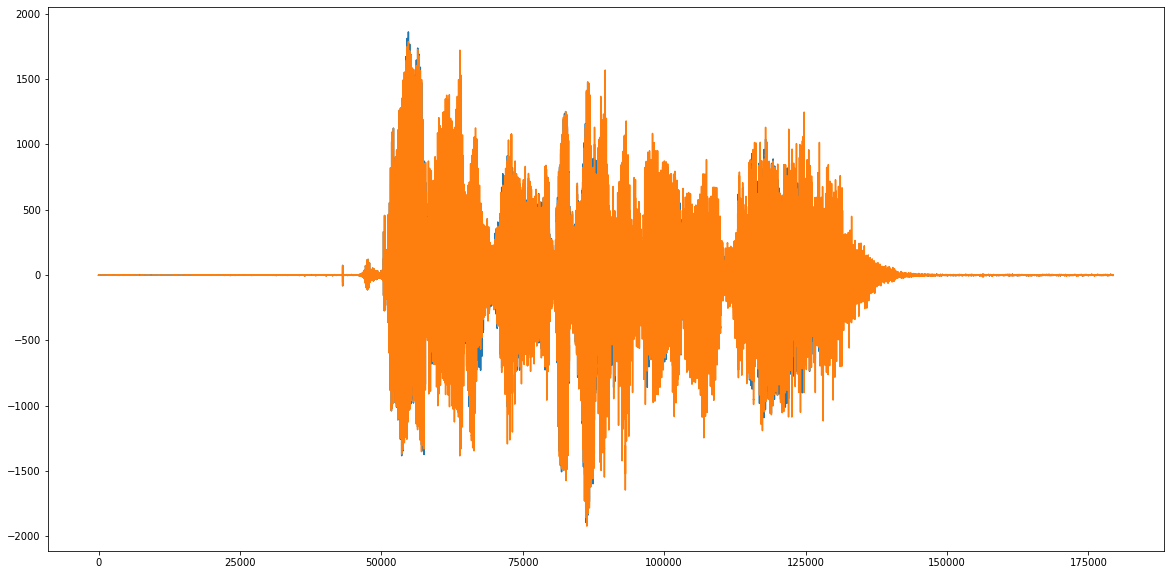

In [12]:
def echo(Nl, a, D, gamma):
    echo_signal = np.zeros(len(signal))
    for delay, alpha in zip(D, a):
        for i in range(delay, len(echo_signal)):
            echo_signal[i] += signal[i-delay]*alpha
            
    low = 3000
    b, a = scipy_signal.butter(1, 2*low/framerate, 'lowpass')
    echo_signal = scipy_signal.filtfilt(b, a, echo_signal)  
    
    for j in range(len(signal)):
        echo_signal[j] = echo_signal[j] * gamma + signal[j]
    
    return echo_signal
    
N_L = 8
a = [0.8, 0.4, 0.2, 0.1, 0.05, 0.025, 0.0125, 0.00625]
gamma = 0.8
D = [7000, 6700, 6400, 5900, 5300, 4800, 4400, 4000]

echo_signal = reverb(N_L, a, D, gamma)

plt.figure(figsize=(20, 10)) 
plt.plot(signal)
plt.plot(echo_signal)
plt.show()

write("echo.wav", framerate, echo_signal.astype(np.int16))

## Классический Distortion (опционально)

Обозначим входной сигнал и выходной сигналы, соответственно как $ x(i) $ и $ y(i) $, $ i = 0,1, . . . , N-1 $. Пользователь задает порог — $ Th $ и максимальное значение сигнала $Max \gt Th $. Тогда

$$
Y(i) =
\begin{cases}
 x(i) ,&amp; |x(i)| \leq Th \\
 Max*sign(x(i))  ,&amp; |x(i)| \gt Th
 \end{cases}       
$$

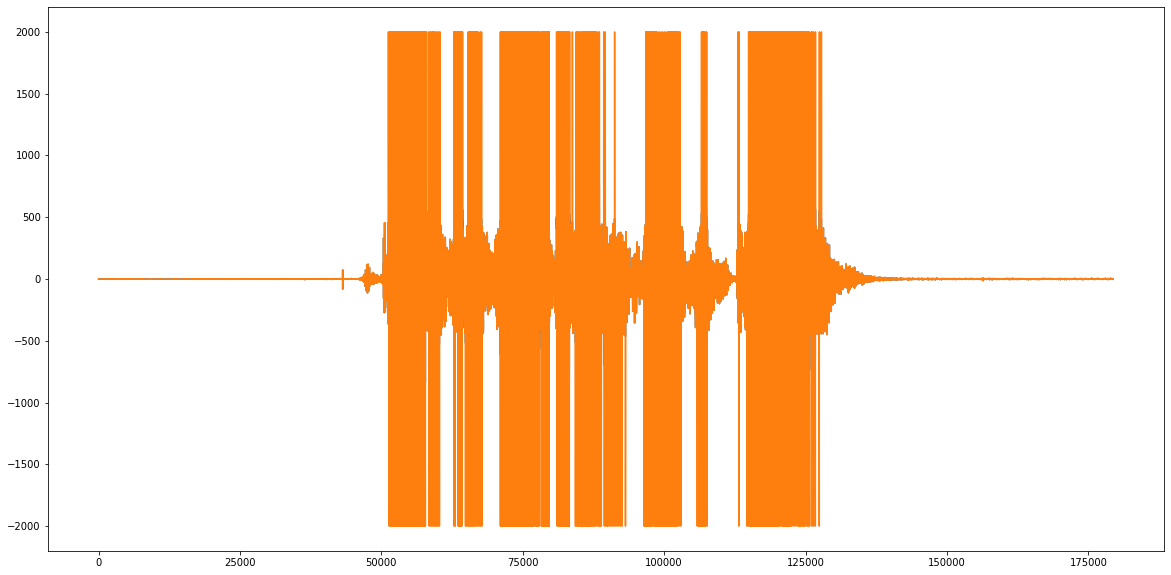

In [18]:
Th = np.sum(np.abs(signal)) / len(signal) * 4
Max = 2000

y = np.empty(len(signal), dtype=np.int16)
for i in range(len(signal)):
    if abs(signal[i]) > Th:
        y[i] = Max * np.sign(signal[i])
    else:
        y[i] = signal[i]
             
plt.figure(figsize=(20, 10))
plt.plot(signal)
plt.plot(y)
plt.show()

write("distortion.wav", framerate, y.astype(np.int16))

## Вывод
В ходе выполнения лабораторной работы были получены навыки работы с jupyter notebook, изучены методы обработки звуковых сигналов. Были описаны следующие методы обработки сигналов: Фильтрация с помощью верхних частот, Амплитудный детектор, Эхо, Distortion. Реализация была осуществлена на языке Python с помощью библиотек: numpy, scipy для вычислений, mathplotlib для отрисовки.